<a href="https://colab.research.google.com/github/DodyDharma440/uts-machine-learning/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set(style="whitegrid")

In [ ]:
# 1. DATA PREPARATION

In [12]:
# A. Data Generation atau Loading
# Set seed untuk reproducibility
np.random.seed(42)

# Jumlah sampel
n_samples = 300

# 1. Luas Tanah (50–500) → integer
luas_tanah = np.random.randint(50, 501, n_samples)

# 2. Luas Bangunan: 60%–100% dari luas tanah, min 30, max 400 → integer
luas_bangunan_ratio = np.random.uniform(0.6, 1.0, n_samples)
luas_bangunan = (luas_tanah * luas_bangunan_ratio).astype(int)
luas_bangunan = np.clip(luas_bangunan, 30, 400)

# 3. Kamar Tidur: berdasarkan luas_bangunan (~1 kamar per 60–80 m²), min 1, max 5
kamar_raw = luas_bangunan / np.random.uniform(60, 80, n_samples)
kamar_tidur = np.round(kamar_raw).astype(int)
kamar_tidur = np.clip(kamar_tidur, 1, 5)

# 4. Umur Bangunan (0–30 tahun) → integer
umur_bangunan = np.random.randint(0, 31, n_samples)

# 5. Jarak ke Pusat Kota (1–20 km) → integer (dibulatkan)
jarak_pusat = np.random.randint(1, 21, n_samples)

# 6. Harga Properti: kombinasi realistis + non-linear
harga = (
    0.7 * luas_tanah +
    1.8 * luas_bangunan +
    80 * kamar_tidur +
    -12 * umur_bangunan +
    -30 * jarak_pusat +
    0.0015 * luas_bangunan**2 +        # non-linear effect
    np.random.normal(0, 70, n_samples) # noise
)

# Batasi rentang harga (200–5000) dan jadikan integer
harga = np.clip(harga, 200, 5000)
harga = np.round(harga).astype(int)

# Buat DataFrame
df = pd.DataFrame({
    'luas_tanah': luas_tanah,
    'luas_bangunan': luas_bangunan,
    'kamar_tidur': kamar_tidur,
    'umur_bangunan': umur_bangunan,
    'jarak_pusat': jarak_pusat,
    'harga': harga
})

print("✅ Dataset integer realistis berhasil dibuat dengan", len(df), "sampel.")
df.head()

✅ Dataset integer realistis berhasil dibuat dengan 300 sampel.


,luas_tanah,luas_bangunan,kamar_tidur,umur_bangunan,jarak_pusat,harga
0,152,130,2,28,7,200
1,485,324,4,7,9,1049
2,398,348,5,4,11,1013
3,320,241,3,28,14,281
4,156,152,2,14,4,335


In [17]:
# B. Exploratory Data Analysis

# Statistical summary
df.describe()


,luas_tanah,luas_bangunan,kamar_tidur,umur_bangunan,jarak_pusat,harga
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,278.236667,220.503333,3.093333,15.380000,10.243333,556.926667
std,125.760565,103.236602,1.396827,8.993621,5.463542,386.843147
min,51.000000,31.000000,1.000000,0.000000,1.000000,200.000000
25%,177.750000,130.750000,2.000000,7.000000,5.000000,200.000000
50%,275.000000,217.000000,3.000000,16.000000,10.000000,429.000000
75%,389.000000,304.250000,4.000000,23.000000,15.000000,833.750000
max,500.000000,400.000000,5.000000,30.000000,20.000000,1548.000000


Visualisasi distribusi setiap fitur:


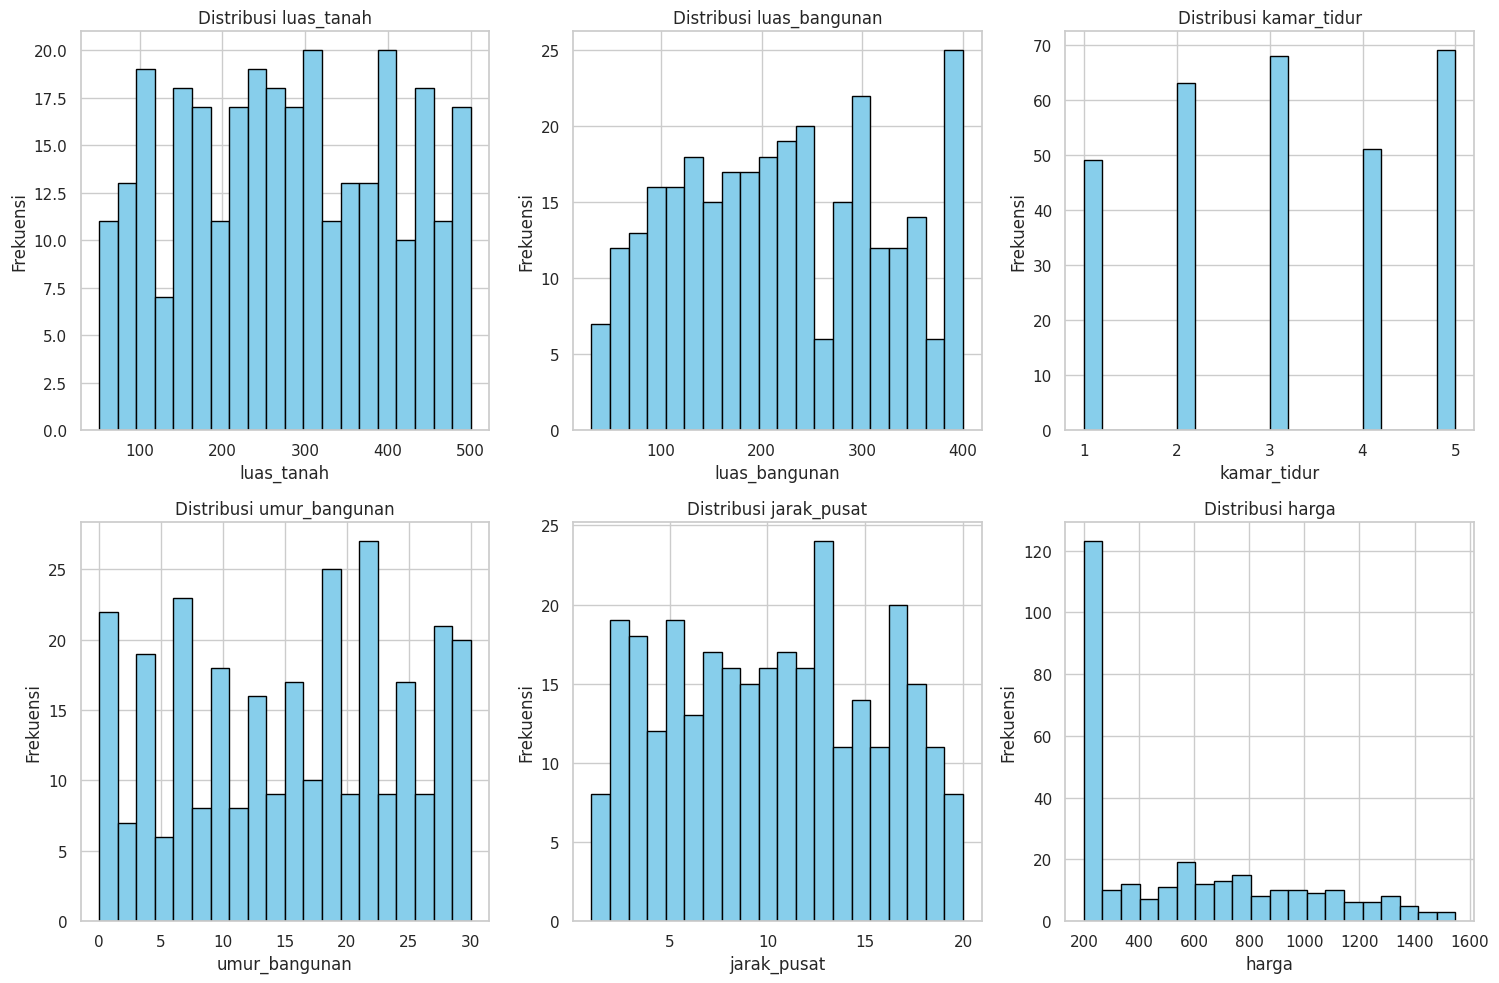

Scatter plot fitur vs harga:


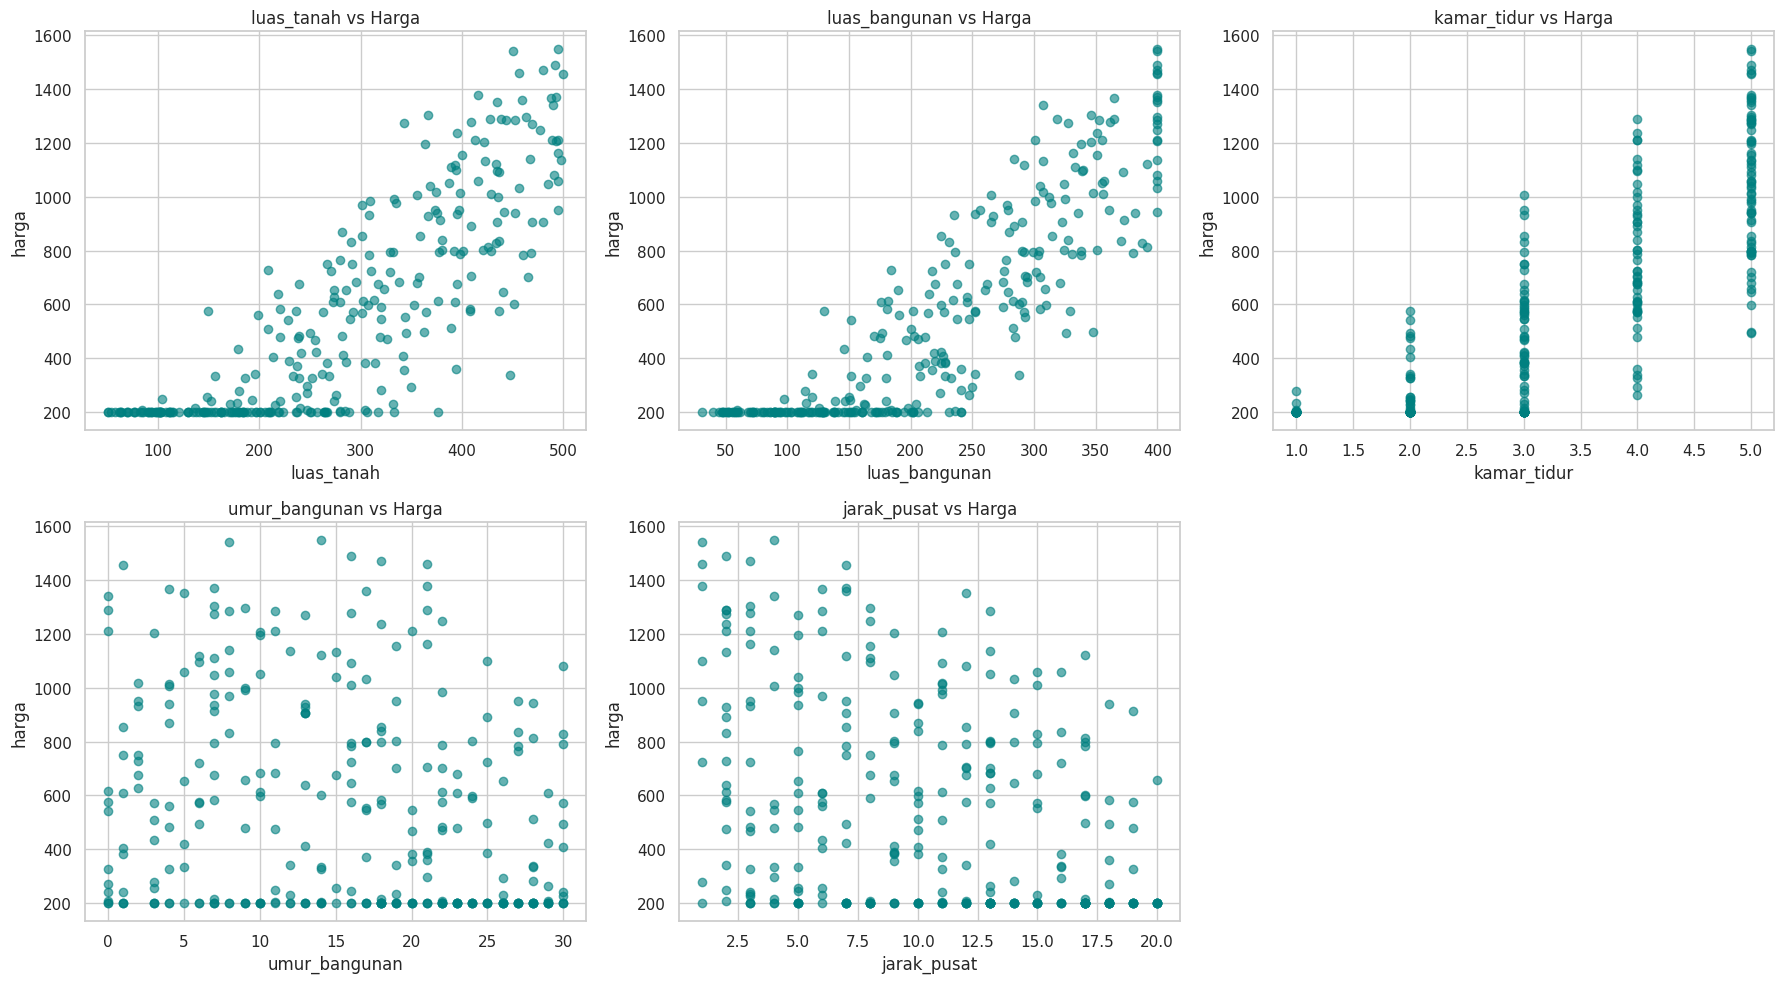

Correlation Matrix (Heatmap):


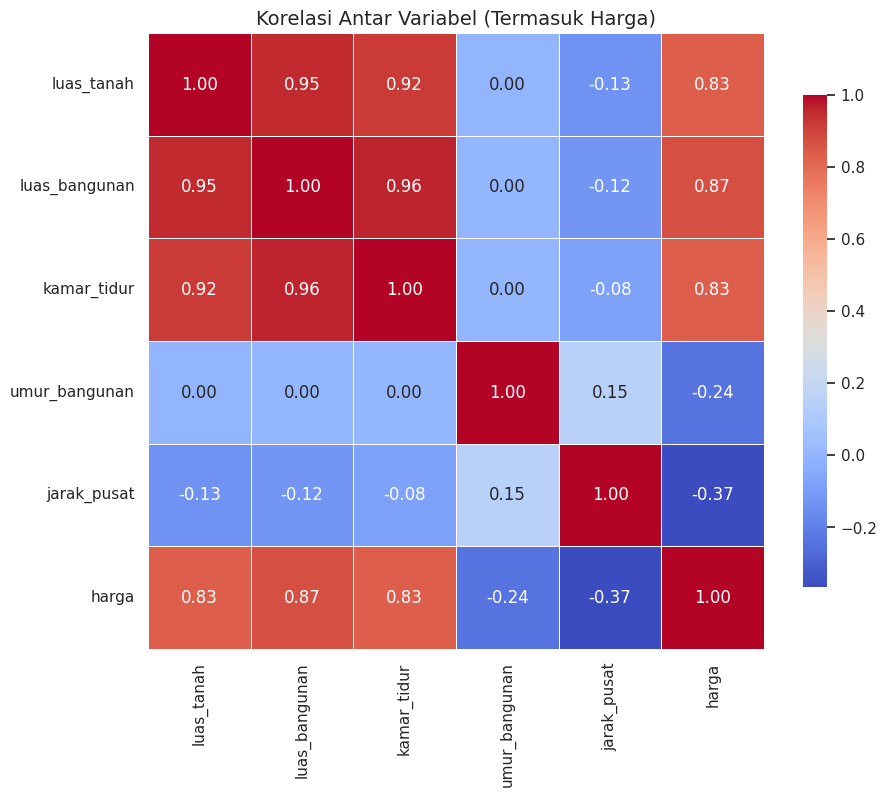

In [20]:
# Visualisasi distribusi setiap fitur
print("Visualisasi distribusi setiap fitur:")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')

# Sembunyikan subplot kosong (karena 6 kolom, tapi grid 2x3 = 6)
plt.tight_layout()
plt.show()

# Scatter plot fitur vs harga
print("Scatter plot fitur vs harga:")
features = ['luas_tanah', 'luas_bangunan', 'kamar_tidur', 'umur_bangunan', 'jarak_pusat']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feat in enumerate(features):
    axes[i].scatter(df[feat], df['harga'], alpha=0.6, color='teal')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('harga')
    axes[i].set_title(f'{feat} vs Harga')

# Sembunyikan subplot terakhir (karena hanya 5 fitur)
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("Correlation Matrix (Heatmap):")
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title("Korelasi Antar Variabel (Termasuk Harga)", fontsize=14)
plt.show()

In [24]:
# Identifikasi outlier
Q1 = df['harga'].quantile(0.25)      # Nilai di bawah 25% data
Q3 = df['harga'].quantile(0.75)      # Nilai di bawah 75% data
IQR = Q3 - Q1                        # Rentang tengah 50% data

lower_bound = Q1 - 1.5 * IQR         # Batas bawah normal
upper_bound = Q3 + 1.5 * IQR         # Batas atas normal

# Cari data yang di luar batas
outliers = df[(df['harga'] < lower_bound) | (df['harga'] > upper_bound)]

print(f"Jumlah outlier: {len(outliers)}")

Jumlah outlier: 0


In [25]:
# C. Data Preprocessing

# Split data
X = df.drop('harga', axis=1)
y = df['harga']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Missing values
print("Missing values:")
print(df.isnull().sum())
print("Tidak ada missing values.")

print("Preprocessing selesai.")

Missing values:
luas_tanah       0
luas_bangunan    0
kamar_tidur      0
umur_bangunan    0
jarak_pusat      0
harga            0
dtype: int64
Tidak ada missing values.
Preprocessing selesai.
